# CS156 - Assignment 2: The Lending Club
---

Author: Snehan Kekre

Affiliation: Minerva Schools at KGI

[Objective](https://seminar.minerva.kgi.edu/app/assignments/46142): Build a model that predicts the largest loan amount that will be **successfully** funded for given individual. 

## Download and Extract the Data

Source: https://www.kaggle.com/wordsforthewise/lending-club

Method: Use the [Kaggle API](https://github.com/Kaggle/kaggle-api) to download the data

In [1]:
!pip install -q kaggle
!mkdir .kaggle

import json
token = {"username":"snehanrhyme","key":"d2b6ab2c54ebd606272879dda79a177b"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

!mkdir ~/.kaggle/
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v /content/
!kaggle datasets download -d wordsforthewise/lending-club

- path is now set to: /content/
 99% 611M/618M [00:05<00:00, 110MB/s]
100% 618M/618M [00:05<00:00, 115MB/s]


In [0]:
# Extract the compressed files
!unzip -q /content/datasets/wordsforthewise/lending-club/lending-club.zip
!gunzip -q accepted_2007_to_2018Q4.csv.gz
!gunzip -q rejected_2007_to_2018Q4.csv.gz

## Import Essential Libraries

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns # Plot styling
from datetime import datetime
import warnings
import re

warnings.simplefilter('ignore') # Supress warnings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(12, 8)})

## Load the Data into Memory

In [5]:
%%time
chunksize = 100000

# Read CSV files in chunks of specified size
accept_raw = pd.read_csv('accepted_2007_to_2018Q4.csv',
                         chunksize=chunksize,
                         iterator=True)
 
reject_raw = pd.read_csv('rejected_2007_to_2018Q4.csv',
                         chunksize=chunksize,
                         iterator=True)

# Convert the TextFileReader objects to dataframes
accepted_df = pd.concat(accept_raw, ignore_index=True)
rejected_df = pd.concat(reject_raw, ignore_index=True)

CPU times: user 1min 43s, sys: 4.92 s, total: 1min 48s
Wall time: 1min 48s


## Basic Data Exploration

In [6]:
accepted_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [8]:
rejected_df.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [9]:
accepted_df.shape, rejected_df.shape
# Order of magnitude difference: class imbalance

((2260701, 151), (27648741, 9))

In [10]:
# Check no. of null values in each column
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{accepted_df.isnull().sum().sort_values()}")

Sum of null values in each feature:
-----------------------------------
id                                                  0
fico_range_high                                    33
hardship_flag                                      33
revol_bal                                          33
initial_list_status                                33
out_prncp                                          33
out_prncp_inv                                      33
total_pymnt                                        33
total_pymnt_inv                                    33
total_rec_prncp                                    33
total_rec_int                                      33
total_rec_late_fee                                 33
recoveries                                         33
last_pymnt_amnt                                    33
last_fico_range_high                               33
last_fico_range_low                                33
policy_code                                        33
applicatio

## Data Preprocessing

The Lending Club's [Data Dictionary](https://web.archive.org/web/20170227081857/https://resources.lendingclub.com/LCDataDictionary.xlsx) includes definitions for all the data attributes included.

**Note**:

`accepted_df` does not contain a `Risk_Score` column

Data Dictionary says the risk score is the borrower's FICO score.

Average the borrower's low and high FICO scores to calculate
the `Risk_Score`

In [0]:
accepted_df.fico_range_high.fillna(accepted_df.fico_range_high.mean(),
                                   inplace=True)

accepted_df.fico_range_low.fillna(accepted_df.fico_range_low.mean(),
                                  inplace=True)

accepted_df['Risk_Score'] = accepted_df[['fico_range_high',
                                         'fico_range_low']].mean(axis=1)

There is a clear class imbalance in the data set. 

Rather than synthetically generating data, we will accomodate the imbalance via stratified sampling.

In [0]:
rejected_df = rejected_df[['Amount Requested', 'Debt-To-Income Ratio', 'Zip Code', 'Employment Length', 'Loan Title', 'Risk_Score']]
accepted_df = accepted_df[['loan_amnt', 'dti', 'zip_code', 'emp_length', 'purpose', 'Risk_Score']]

pd.options.mode.chained_assignment = None

rejected_df.columns = ['amount', 'dti', 'zip', 'emp_length', 'purpose', 'risk']
accepted_df.columns = ['amount', 'dti', 'zip', 'emp_length', 'purpose', 'risk']

In [0]:
rejected_df.dropna(inplace=True)
accepted_df.dropna(inplace=True)

rejected_df['dti'] = rejected_df['dti'].apply(lambda x: x.strip('%')).astype(float)
rejected_df['zip'] = rejected_df['zip'].str.extract('(\d+)')
rejected_df['zip'] = rejected_df['zip'].str.slice(0, 2).astype(float)
rejected_df['emp_length'] = rejected_df['emp_length'].str.extract('(\d+)').astype(float)
rejected_df['accept'] = 0

accepted_df['emp_length'] = accepted_df['emp_length'].str.extract('(\d+)').astype(float)
accepted_df['zip'] = accepted_df['zip'].str.extract('(\d+)')
accepted_df['zip'] = accepted_df['zip'].str.slice(0, 2).astype(float)
accepted_df['accept'] = 1

In [14]:
all_data = pd.concat([accepted_df, rejected_df])
all_data['accept'] = all_data['accept'].astype(float)
all_data.dtypes

amount        float64
dti           float64
zip           float64
emp_length    float64
purpose        object
risk          float64
accept        float64
dtype: object

In [15]:
all_data['purpose'].value_counts()[:30]

debt_consolidation         2952678
Debt consolidation         2391342
credit_card                 928176
Other                       829322
Credit card refinancing     678080
other                       676037
home_improvement            338998
Car financing               301511
Home improvement            204832
car                         186538
major_purchase              177278
Medical expenses            159518
small_business              156769
moving                      140938
medical                     139352
Major purchase              127895
Moving and relocation       127095
Home buying                 114972
Business                     99223
house                        68070
vacation                     62113
Vacation                     52848
wedding                      19868
Green loan                   13284
                             12648
renewable_energy             11764
Debt Consolidation            4973
educational                   2246
debt consolidation  

In [16]:
def feature_eng_purpose(x):
  purpose = str(x).lower()
  if 'debt' in purpose: return 'debt'
  if 'credit' in purpose: return 'credit_card'
  if 'home' in purpose: return 'home'
  if 'car' in purpose: return 'car'
  if 'medical' in purpose: return 'medical'
  if 'business' in purpose: return 'business'
  if 'moving' in purpose: return 'moving'
  if 'major' in purpose: return 'major_purchases'
  if 'house' in purpose: return 'home'
  if 'vacation' in purpose: return 'vacation'
  if 'wedding' in purpose: return 'wedding'
  return 'other'

purpose_df = all_data['purpose'].apply(feature_eng_purpose)
purpose_dummies = pd.get_dummies(purpose_df, dtype=float)
final_df = pd.concat([all_data, purpose_dummies], axis=1)
final_df.drop(['purpose'], axis=1, inplace=True)
final_df.head()

,amount,dti,zip,emp_length,risk,accept,business,car,credit_card,debt,home,major_purchases,medical,moving,other,vacation,wedding
0,3600.0,5.91,19.0,10.0,677.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24700.0,16.06,57.0,10.0,717.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20000.0,10.78,60.0,10.0,697.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35000.0,17.06,7.0,10.0,787.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10400.0,25.37,17.0,3.0,697.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
len(final_df.zip.unique())

100

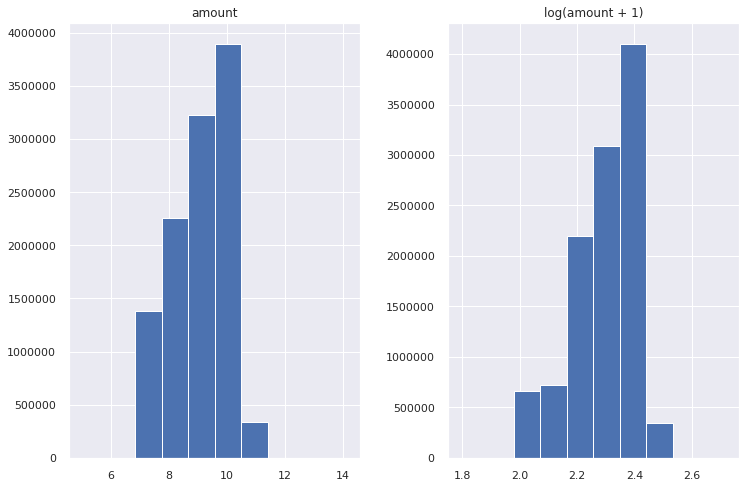

In [25]:
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(12, 8)})

amount = pd.DataFrame({"amount":final_df["amount"], "log(amount + 1)":np.log1p(final_df["amount"])})
amount.hist();

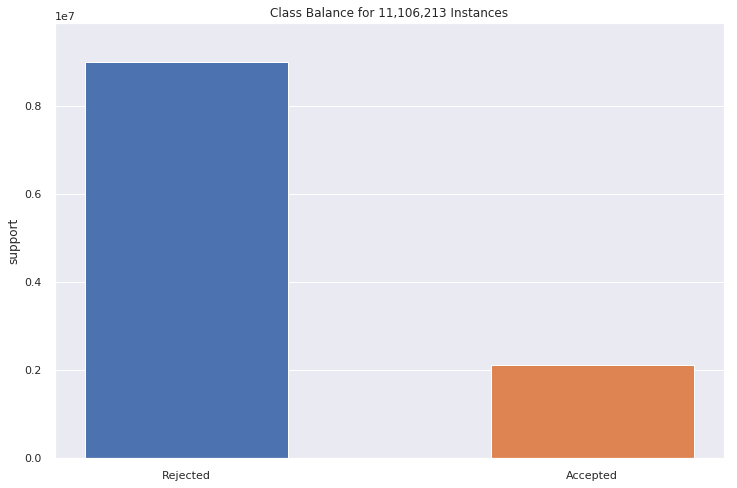

In [36]:
from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels=["Rejected","Accepted"])
visualizer.fit(final_df.accept.values)
visualizer.poof()

In [0]:
#log transform skewed numeric feature
final_df['amount'] = np.log1p(final_df['amount'])

In [0]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder, OrdinalEncoder

In [29]:
final_df.head()

,amount,dti,zip,emp_length,risk,accept,business,car,credit_card,debt,home,major_purchases,medical,moving,other,vacation,wedding
0,1.168761,5.91,19.0,10.0,677.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.226202,16.06,57.0,10.0,717.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.220561,10.78,60.0,10.0,697.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.235220,17.06,7.0,10.0,787.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.202144,25.37,17.0,3.0,697.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from sklearn.model_selection import train_test_split

X = final_df.loc[:, final_df.columns!='accept']
y = final_df.loc[:, final_df.columns=='accept']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8884970, 16), (8884970, 1), (2221243, 16), (2221243, 1))

In [32]:
import xgboost as xgb

clf = xgb.XGBClassifier(learning_rate=0.1,
                        n_estimators=200,
                        min_child_weight=8,
                        scale_pos_weight=1,
                        objective= 'binary:logistic',
                        seed=27,
                        tree_method='gpu_hist',
                        metric='auc')
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3, metric='auc',
              min_child_weight=8, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [33]:
from sklearn.metrics import *

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.958082028846011

In [34]:
f1_score(y_test, y_pred)

0.8890858366746955

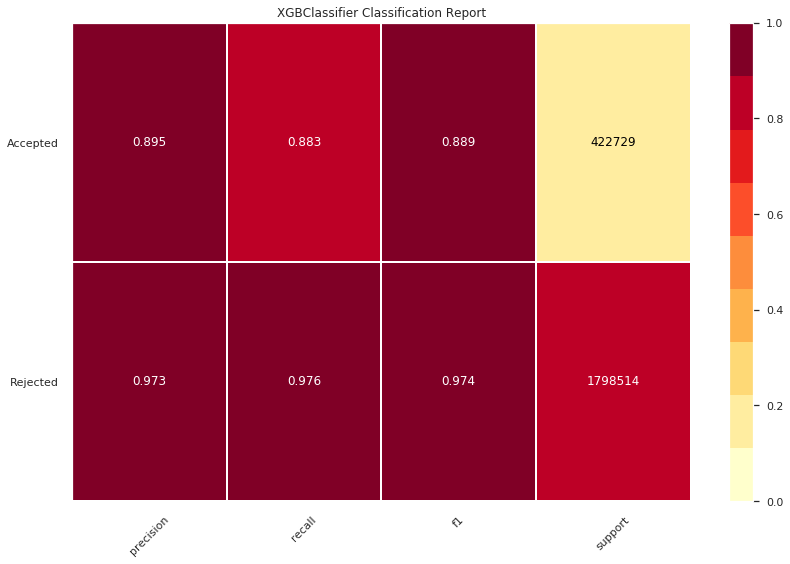

In [37]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import DiscriminationThreshold

visualizer = ClassificationReport(clf, classes=["Rejected", "Accepted"], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()    

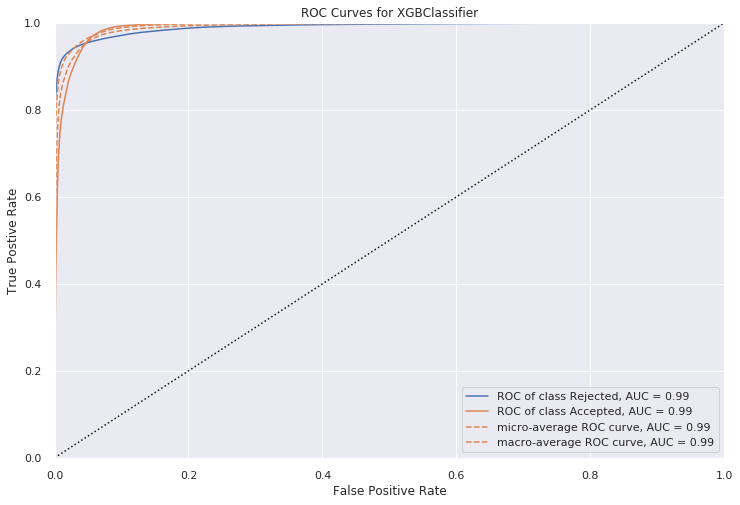

In [39]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(clf, classes=["Rejected", "Accepted"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.poof()                      

In [0]:
max_loan_data = final_df.amount.max() + 1/5 * final_df.amount.max()
#loan_range = np.arange(max_loan_data,  0, -250)
loan_range = np.linspace(max_loan_data, 0, 10000)
def max_accepted_loan(test):
  loans = []
  for loan in loan_range:
    inputs = test
    inputs.insert(0, "amount", loan)
    reject = clf.predict_proba(inputs)[0][0]
    accept = clf.predict_proba(inputs)[0][1]

    if accept == 1: return round(np.expm1(loan), 2)
    if accept > 0.4 and accept < 0.91: return round(np.expm1(loan), 2), accept
    else:
      return("We are unable to provide you with a loan at this time.")

In [0]:
max_accepted_loan(X_test.iloc[0:1, 1:16])

(23733074.19, 0.756856)

In [0]:
clf.predict_proba(X_test.iloc[0:1, 0:16])[0][1]

0.88529974

In [0]:
np.expm1(16.98238021)

23733074.17032291

In [0]:
np.linspace(max_loan_data, 0, 1000)

array([16.98238021, 16.96538083, 16.94838145, 16.93138207, 16.91438269,
       16.89738331, 16.88038393, 16.86338455, 16.84638517, 16.82938579,
       16.81238641, 16.79538704, 16.77838766, 16.76138828, 16.7443889 ,
       16.72738952, 16.71039014, 16.69339076, 16.67639138, 16.659392  ,
       16.64239262, 16.62539324, 16.60839386, 16.59139448, 16.5743951 ,
       16.55739572, 16.54039634, 16.52339696, 16.50639758, 16.4893982 ,
       16.47239882, 16.45539944, 16.43840006, 16.42140068, 16.4044013 ,
       16.38740192, 16.37040255, 16.35340317, 16.33640379, 16.31940441,
       16.30240503, 16.28540565, 16.26840627, 16.25140689, 16.23440751,
       16.21740813, 16.20040875, 16.18340937, 16.16640999, 16.14941061,
       16.13241123, 16.11541185, 16.09841247, 16.08141309, 16.06441371,
       16.04741433, 16.03041495, 16.01341557, 15.99641619, 15.97941681,
       15.96241744, 15.94541806, 15.92841868, 15.9114193 , 15.89441992,
       15.87742054, 15.86042116, 15.84342178, 15.8264224 , 15.80

In [0]:
X = final_df.iloc[:,1:16]
y = final_df.amount

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
model_xgb = xgb.XGBRegressor(max_depth=3,
                             learning_rate=0.1,
                             n_estimators=300,
                             objective='reg:squarederror',
                             metric='rmse',
                             tree_method='gpu_hist')
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, metric='rmse', min_child_weight=1, missing=None,
             n_estimators=300, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, tree_method='gpu_hist', verbosity=1)

In [0]:
xgb_preds = model_xgb.predict(X_test)

In [0]:
print("XGB MSE on validation set: ", mean_squared_error(y_test, xgb_preds))
print("XGB R^2: ", r2_score(y_test, xgb_preds))

XGB MSE on validation set:  0.7226114175164672
XGB R^2:  0.2815347185531628


## Old

In [0]:
rejected_df['Debt-To-Income Ratio'] = rejected_df['Debt-To-Income Ratio'].apply(lambda x: x.strip('%')).astype(np.float64) #remove % character and convert to float
rejected_df.rename(columns={"Debt-To-Income Ratio": "dti"}, inplace=True) #rename column Debt-To-Income Ratio to dti
rejected_df.drop(columns=['Loan Title'], inplace=True)
rejected_df['Zip Code'].fillna('', inplace=True)
rejected_df['Zip Code'] = rejected_df['Zip Code'].str.extract('(\d+)') #extract only the numeric part (exclude xxx using RegExp)
rejected_df['Application Date'] = pd.to_datetime(rejected_df['Application Date'], yearfirst=True, infer_datetime_format=True) #convert Application Date to pandas.DateTime
rejected_df['Employment Length'] = rejected_df['Employment Length'].str.extract('(\d+)').astype(np.float64) #extract only numeric part and convert to float64
rejected_df.head()

,Amount Requested,Application Date,Risk_Score,dti,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,693.0,10.00,481,NM,4.0,0.0
1,1000.0,2007-05-26,703.0,10.00,010,MA,1.0,0.0
2,11000.0,2007-05-27,715.0,10.00,212,MD,1.0,0.0
3,6000.0,2007-05-27,698.0,38.64,017,MA,1.0,0.0
4,1500.0,2007-05-27,509.0,9.43,209,MD,1.0,0.0


In [0]:
rejected_df = reduce_mem_usage(rejected_df)

Mem. usage decreased to 1160.19 Mb (31.2% reduction)


In [0]:
sum(accepted_df.loan_amnt !=	accepted_df.funded_amnt)

2098

In [0]:
accepted_df.zip_code = accepted_df.zip_code.str.extract('(\d+)') #extract only the numeric part (exclude xxx using RegExp)
rejected_df.rename(columns={"Zip Code": "zip_code"}, inplace=True)

In [0]:
accepted_df.emp_length = accepted_df.emp_length.str.extract('(\d+)').astype(np.float64) #extract only numeric part and convert to float64
rejected_df.rename(columns={"Employment Length": "emp_length"}, inplace=True)

In [0]:
rejected_df.rename(columns={"Policy Code": "policy_code"}, inplace=True)

In [0]:
accepted_df.rename(columns={"loanAmnt": "loan_amount"}, inplace=True)
rejected_df.rename(columns={"Amount Requested": "loan_amount"}, inplace=True)

In [0]:
rejected_df.drop(columns=["Application Date"], inplace=True)

In [0]:
sum(accepted_df.fico_range_low.isna())

33

In [0]:
rejected_df.head()

,loan_amount,Risk_Score,dti,zip_code,State,emp_length,policy_code
0,1000.0,693.0,10.000000,481,NM,4.0,0.0
1,1000.0,703.0,10.000000,010,MA,1.0,0.0
2,11000.0,715.0,10.000000,212,MD,1.0,0.0
3,6000.0,698.0,38.639999,017,MA,1.0,0.0
4,1500.0,509.0,9.430000,209,MD,1.0,0.0


In [0]:
accepted_df.rename(columns={"loan_amnt":"loan_amount"}, inplace=True)

In [0]:
accepted_df.rename(columns={"addr_state":"State"}, inplace=True)

In [0]:
accepted_df.State.dropna(axis=0, inplace=True)
rejected_df.State.dropna(axis=0, inplace=True)

In [0]:
accepted_df['accepted'] = 1
rejected_df['accepted'] = 0

In [0]:
rejected_df.columns

Index(['loan_amount', 'Risk_Score', 'dti', 'zip_code', 'State', 'emp_length',
       'policy_code', 'accepted'],
      dtype='object')

In [0]:
accepted_df_final = accepted_df[['loan_amount', 'Risk_Score', 'dti', 'zip_code', 'State', 'emp_length', 'policy_code', 'accepted']]
accepted_df_final.head()

,loan_amount,Risk_Score,dti,zip_code,State,emp_length,policy_code,accepted
0,3600.0,677.0,5.91,190,PA,10.0,1.0,1
1,24700.0,717.0,16.06,577,SD,10.0,1.0,1
2,20000.0,697.0,10.78,605,IL,10.0,1.0,1
3,35000.0,787.0,17.06,076,NJ,10.0,1.0,1
4,10400.0,697.0,25.37,174,PA,3.0,1.0,1


In [0]:
data = pd.concat([accepted_df_final, rejected_df], axis=0)
data.head()

,loan_amount,Risk_Score,dti,zip_code,State,emp_length,policy_code,accepted
0,3600.0,677.0,5.91,190,PA,10.0,1.0,1
1,24700.0,717.0,16.06,577,SD,10.0,1.0,1
2,20000.0,697.0,10.78,605,IL,10.0,1.0,1
3,35000.0,787.0,17.06,076,NJ,10.0,1.0,1
4,10400.0,697.0,25.37,174,PA,3.0,1.0,1


In [0]:
pd.get_dummies(data.State).shape

(29909442, 51)

In [0]:
len(data.zip_code.unique())

1002

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [0]:
del accepted_df, rejected_df, accepted_df_final, amount, 

In [0]:
from scipy.stats import skew
#log transform the target
data['loan_amount'] = np.log1p(data['loan_amount'])

In [0]:
data.policy_code = data.policy_code.astype(str)
data.zip_code = data.zip_code.astype(str)
data.State = data.State.astype(str)
data.accepted = data.accepted.astype(str)

In [0]:
data.dtypes

loan_amount    float64
Risk_Score     float64
dti            float64
zip_code        object
State           object
emp_length     float64
policy_code     object
accepted        object
dtype: object

In [0]:
#find numeric features
numeric_features = data.dtypes[data.dtypes != "object"].index

In [0]:
#compute skew
skewed_features = data[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index
#log transform skewed numeric features
data[skewed_features] = np.log1p(data[skewed_features])

In [0]:
#data = data.fillna(data.mean())
data.head()

,loan_amount,Risk_Score,dti,zip_code,State,emp_length,policy_code,accepted
0,8.188967,677.0,1.932970,190,PA,2.397895,1.0,1
1,10.114599,717.0,2.836737,577,SD,2.397895,1.0,1
2,9.903538,697.0,2.466403,605,IL,2.397895,1.0,1
3,10.463132,787.0,2.893700,076,NJ,2.397895,1.0,1
4,9.249657,697.0,3.272227,174,PA,1.386294,1.0,1


In [0]:
data.accepted = pd.get_dummies(columns=data.accepted)
data.policy_code = pd.get_dummies(data.policy_code)

In [0]:
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 
data['State'] = le.fit_transform(data['State'])
data['policy_code'] = le.fit_transform(data['policy_code'])
data['zip_code'] = le.fit_transform(data['zip_code'])
data['accepted'] = le.fit_transform(data['accepted'])

In [0]:
#create dummies for categorical features
#data = pd.get_dummies(data)
#data = pd.get_dummies(data, columns=["zip_code", "State", "policy_code", "accepted"])

#replace NANs with the mean of the column
#data = data.fillna(data.mean())

In [0]:
data.head()

,loan_amount,Risk_Score,dti,zip_code,State,emp_length,policy_code,accepted
0,8.188967,677.0,1.932970,191,38,2.397895,1,1
1,10.114599,717.0,2.836737,578,41,2.397895,1,1
2,9.903538,697.0,2.466403,606,14,2.397895,1,1
3,10.463132,787.0,2.893700,76,31,2.397895,1,1
4,9.249657,697.0,3.272227,175,38,1.386294,1,1


In [0]:
data.dtypes

loan_amount    float64
Risk_Score     float64
dti            float64
zip_code         int64
State            int64
emp_length     float64
policy_code      int64
accepted         int64
dtype: object

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.Risk_Score = scaler.fit_transform(np.array(data.Risk_Score).reshape(-1,1))
data.head()

,loan_amount,Risk_Score,dti,zip_code,State,emp_length,policy_code,accepted
0,8.188967,0.397234,1.932970,190,PA,2.397895,1.0,1
1,10.114599,0.858035,2.836737,577,SD,2.397895,1.0,1
2,9.903538,0.627635,2.466403,605,IL,2.397895,1.0,1
3,10.463132,1.664436,2.893700,076,NJ,2.397895,1.0,1
4,9.249657,0.627635,3.272227,174,PA,1.386294,1.0,1


In [0]:
#data = pd.get_dummies(data, columns=['policy_code', 'accepted'])
data.head()

,loan_amount,Risk_Score,dti,zip_code,State,emp_length,policy_code,accepted
0,8.188967,0.397234,1.932970,190,PA,2.397895,0,0
1,10.114599,0.858035,2.836737,577,SD,2.397895,0,0
2,9.903538,0.627635,2.466403,605,IL,2.397895,0,0
3,10.463132,1.664436,2.893700,076,NJ,2.397895,0,0
4,9.249657,0.627635,3.272227,174,PA,1.386294,0,0


In [0]:
new_df = pd.get_dummies(data, columns=['policy_code', 'accepted'])
new_df.head()

,loan_amount,Risk_Score,dti,zip_code,State,emp_length,policy_code_0.0,policy_code_1.0,policy_code_2.0,policy_code_nan,accepted_0,accepted_1
0,8.188967,0.397234,1.932970,190,PA,2.397895,0,1,0,0,0,1
1,10.114599,0.858035,2.836737,577,SD,2.397895,0,1,0,0,0,1
2,9.903538,0.627635,2.466403,605,IL,2.397895,0,1,0,0,0,1
3,10.463132,1.664436,2.893700,076,NJ,2.397895,0,1,0,0,0,1
4,9.249657,0.627635,3.272227,174,PA,1.386294,0,1,0,0,0,1


In [0]:
del data
data = new_df

In [0]:
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder()
data['State'] = le.fit_transform(data['State'])
data['zip_code'] = le.fit_transform(data['zip_code'])

In [0]:
data.dtypes

loan_amount        float64
Risk_Score         float64
dti                float64
zip_code             int64
State                int64
emp_length         float64
policy_code_0.0      uint8
policy_code_1.0      uint8
policy_code_2.0      uint8
policy_code_nan      uint8
accepted_0           uint8
accepted_1           uint8
dtype: object

In [0]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
data.policy_code = onehot.fit_transform(np.array(data.policy_code).reshape(-1,1))
data.accepted = onehot.fit_transform(np.array(data.accepted).reshape(-1,1))
data.State = onehot.fit(np.array(data.State).reshape(-1,1))
data.head()

In [0]:
data.columns

Index(['loan_amount', 'Risk_Score', 'dti', 'zip_code', 'State', 'emp_length',
       'policy_code_0.0', 'policy_code_1.0', 'policy_code_2.0',
       'policy_code_nan', 'accepted_0', 'accepted_1'],
      dtype='object')

In [0]:
data.dropna(axis=0, how='any', inplace=True)

In [0]:
data.isnull().values.any()

False

In [0]:
from sklearn.model_selection import train_test_split

X = data[['Risk_Score', 'dti', 'zip_code', 'State', 'emp_length',
       'policy_code_0.0', 'policy_code_1.0', 'policy_code_2.0',
       'policy_code_nan', 'accepted_0', 'accepted_1']]
y = data.loan_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8884994, 11), (2221249, 11), (8884994,), (2221249,))

In [0]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score

def mse_cv(model):
    mse = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 3)
    return mse

In [0]:
#model 1: Ridge Regression Estimator
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10]

#perform 5-fold CV to find the alpha value that minimizes MSE
cv_ridge = [mse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("MSE");
print("Lowest MSE = ", cv_ridge.min())

ValueError: ignored

In [0]:
import warnings
warnings.simplefilter("ignore")
model_ridge = Ridge(alpha=10).fit(X_train, y_train) #use the alpha from the above cell
mse_cv(model_ridge).mean()

ValueError: ignored

In [0]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

params = {"max_depth":1, "eta":0.1, "tree_method":"gpu_hist"}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [0]:
model_xgb = xgb.XGBRegressor(*params, objective='reg:squarederror')
model_xgb.fit(X_train, y_train)

TypeError: ignored

In [0]:
X_train.dtypes

Risk_Score         float64
dti                float64
zip_code             int64
State                int64
emp_length         float64
policy_code_0.0      uint8
policy_code_1.0      uint8
policy_code_2.0      uint8
policy_code_nan      uint8
accepted_0           uint8
accepted_1           uint8
dtype: object